In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import yaml
import sys
sys.path.append('./../..')
from dynaphos import utils

import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import linregress, norm

import matplotlib.pyplot as plt

# import tqdm
# from tqdm.notebook import trange, tqdm
from tqdm.autonotebook import tqdm as notebook_tqdm

COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')
plt.style.use('../_figurestyle/small.mplstyle')
# %matplotlib qt
params = utils.load_params('../dynaphos-core/config/params.yaml')


C:\Users\grinten\AppData\Local\Temp\ipykernel_12632\766374187.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as notebook_tqdm


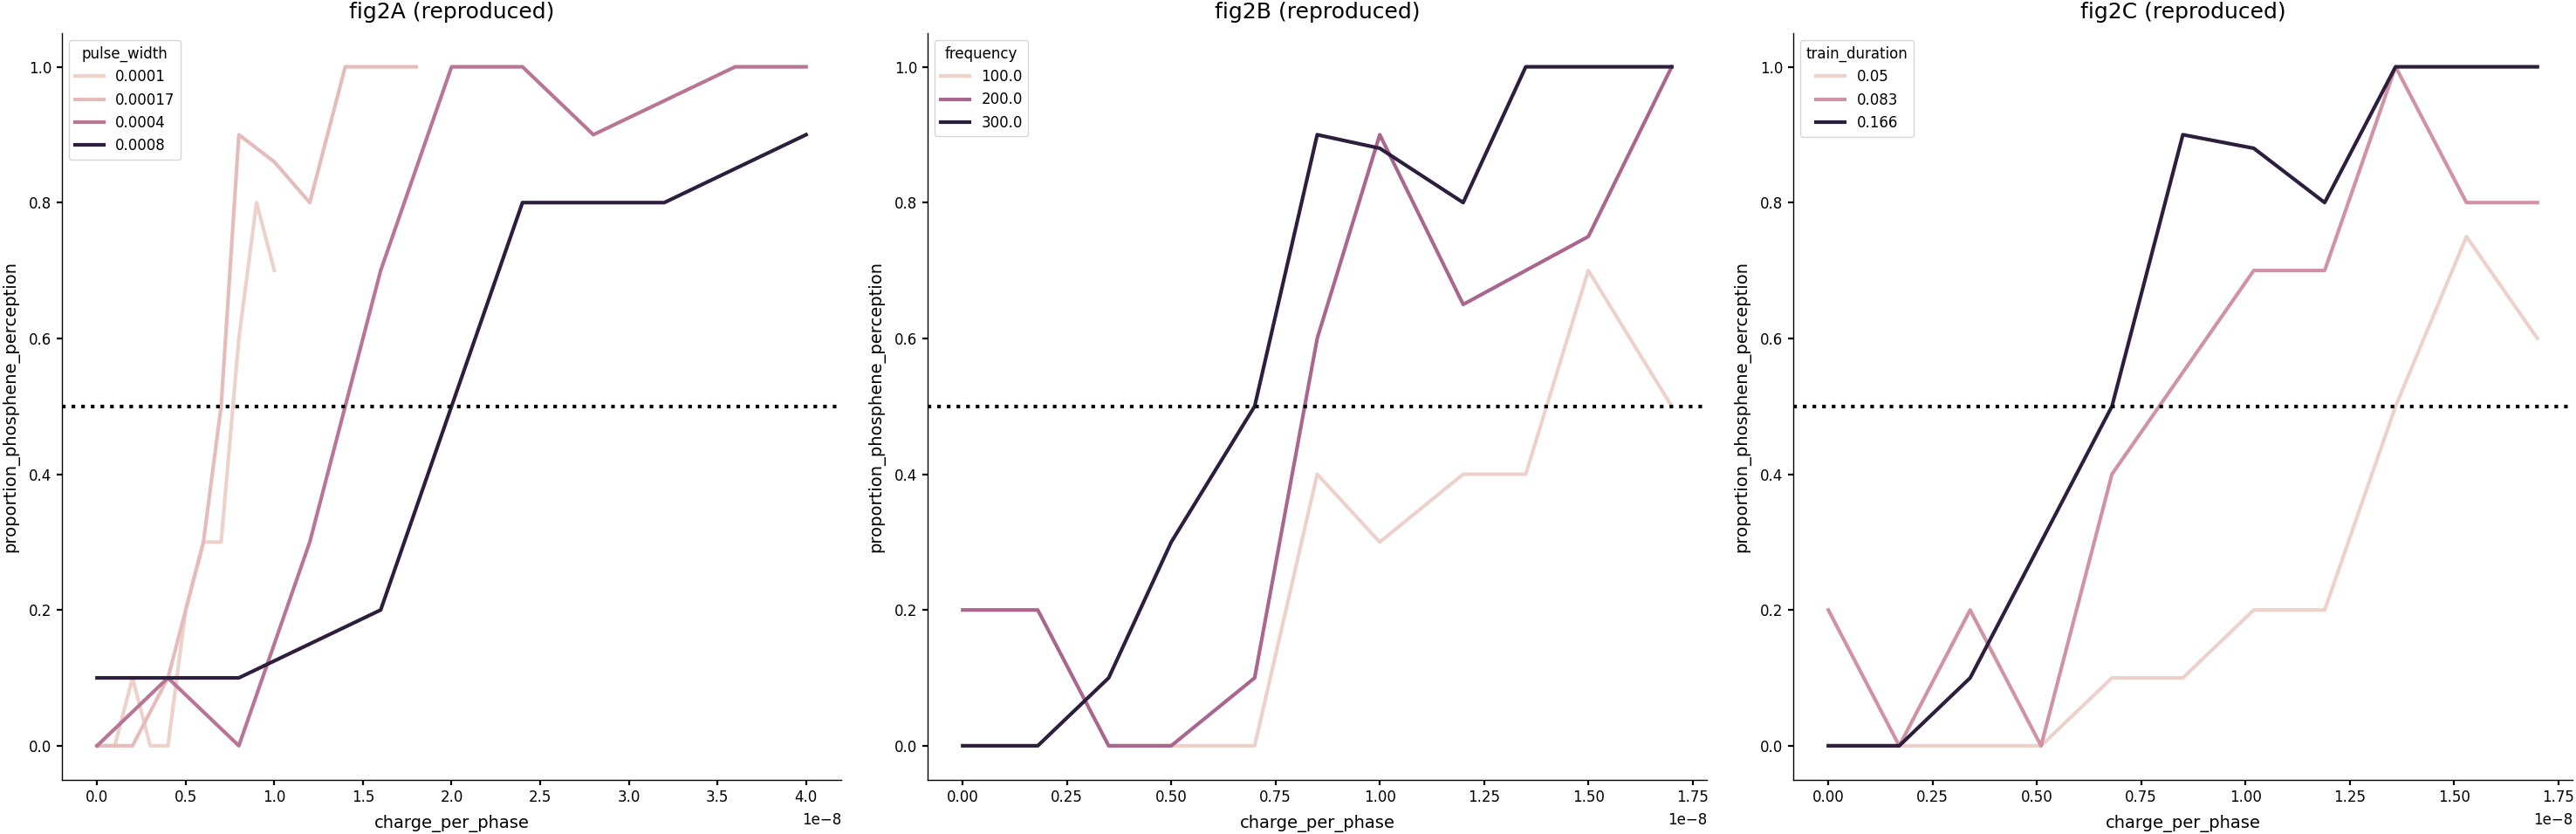

In [2]:
# Default stimulation parameters in Fernandez et al 2021
DEFAULT = pd.Series({'pulse_width'    : 170e-6,
                     'frequency'      : 300,
                     'train_duration' : 166e-3})

# Proportion of phosphene perception in figure 2 Fernandez et al 2021
PROPORTIONS = pd.read_csv('data/Fernandez_et_al_2021_fig2.csv',float_precision='high')

# 50 percent detection thresholds (based on the fit by Fernandez et al fig 2)
THRESHOLDS  = pd.read_csv('data/Fernandez_et_al_2021_fig2_50perc_thresholds.csv',float_precision='high')

## VISUALIZE
fig, axs = plt.subplots(1,3,figsize=(15,5),dpi=200)
for i, (label, param) in enumerate([ ('fig2A','pulse_width'),
                                    ('fig2B','frequency'),
                                    ('fig2C','train_duration')]):
    sns.lineplot(data=PROPORTIONS.loc[PROPORTIONS.label==label],
                 x='charge_per_phase',
                 y='proportion_phosphene_perception',
                 hue=param,
                 ax = axs[i])
    axs[i].set(title=f'{label} (reproduced)')
    axs[i].axhline(0.5, color='k', linestyle=':')

plt.tight_layout()

## Uncomment to look at the detection thresholds
# THRESHOLDS

In [3]:
def add_complementary_parameters(data):
    data['amplitude']  = data.charge_per_phase/data.pulse_width
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration
    data['duty_cycle'] = data.pulse_width*data.frequency
    data['corrected_duration'] = data.duty_cycle * data.train_duration
    return data

# Calculate other descriptive parameters and add to the dataframe
add_complementary_parameters(PROPORTIONS)
add_complementary_parameters(THRESHOLDS)

,pulse_width,frequency,train_duration,charge_per_phase,label,amplitude,charge_per_trial,duty_cycle,corrected_duration
0,0.00010,300,0.166,7.500000e-09,fig2A,0.000075,3.735000e-07,0.030,0.004980
1,0.00017,300,0.166,7.000000e-09,fig2A,0.000041,3.486000e-07,0.051,0.008466
2,0.00040,300,0.166,1.600000e-08,fig2A,0.000040,7.968000e-07,0.120,0.019920
3,0.00080,300,0.166,2.000000e-08,fig2A,0.000025,9.960000e-07,0.240,0.039840
4,0.00017,100,0.166,1.400000e-08,fig2B,0.000082,2.324000e-07,0.017,0.002822
5,0.00017,200,0.166,9.000000e-09,fig2B,0.000053,2.988000e-07,0.034,0.005644
6,0.00017,300,0.166,6.000000e-09,fig2B,0.000035,2.988000e-07,0.051,0.008466
7,0.00017,300,0.050,1.390000e-08,fig2C,0.000082,2.085000e-07,0.051,0.002550
8,0.00017,300,0.083,8.500000e-09,fig2C,0.000050,2.116500e-07,0.051,0.004233
9,0.00017,300,0.166,6.300000e-09,fig2C,0.000037,3.137400e-07,0.051,0.008466


In [4]:
THRESHOLDS.shape, PROPORTIONS.shape

((10, 9), (102, 10))

In [5]:
rng = np.random.default_rng(42)
idxs = np.arange(len(THRESHOLDS))
rng.shuffle(idxs)
test_splits = np.split(idxs,[3,6])
test_splits

[array([5, 6, 0]), array([7, 3, 2]), array([4, 9, 1, 8])]

In [6]:
def get_additional_stim_data(n_datapoints=150, I_max=120e-6, ):
    """Produce some new stimulation datapoints, for evaluating the (simulated) effects.
    Using more datapoints can be helpful for a smooth visualization of the modelled responses."""
    i = np.linspace(0.,I_max, n_datapoints)
    pws = np.array([100e-6, 170e-6, 400e-6,800e-6,])
    fs = np.array([100.,200.,300.])
    dur = np.array([50.*1e-3, 83.*1e-3, 166.*1e-3])

    PW, F, TD, I = np.meshgrid(pws,fs,dur,i) ### all permutations of I, pw fs and duration
    data = pd.DataFrame({'pulse_width': PW.flatten(),
                         'frequency': F.flatten(),
                         'train_duration': TD.flatten(),
                         'amplitude': I.flatten(),
                         'mask_pulse_width': False,
                         'mask_frequency': False,
                         'mask_train_duration': False})
    data['charge_per_phase']  = data.amplitude*data.pulse_width
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration

    #
    data.loc[(data.frequency == DEFAULT.frequency) & (data.train_duration == DEFAULT.train_duration), 'mask_pulse_width'] = True
    data.loc[(data.pulse_width == DEFAULT.pulse_width) & (data.train_duration == DEFAULT.train_duration), 'mask_frequency'] = True
    data.loc[(data.frequency == DEFAULT.frequency) & (data.pulse_width == DEFAULT.pulse_width), 'mask_train_duration'] = True
    return data

def get_additional_stim_data2(thresholds, n_datapoints=150, I_max=120e-6):
    data = []
    for index, row in thresholds.iterrows():
        for i in np.linspace(0., I_max, n_datapoints):
            pw, f, td = row[['pulse_width', 'frequency', 'train_duration']]
            entry = [pw, f, td, i, False, False, False]
            data.append(entry)
    data = pd.DataFrame(data, columns=['pulse_width',
                                       'frequency',
                                       'train_duration',
                                       'amplitude',
                                       'mask_pulse_width',
                                       'mask_frequency',
                                       'mask_train_duration'])

    data['charge_per_phase']  = data.amplitude*data.pulse_width
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration

    #
    data.loc[(data.frequency == DEFAULT.frequency) & (data.train_duration == DEFAULT.train_duration), 'mask_pulse_width'] = True
    data.loc[(data.pulse_width == DEFAULT.pulse_width) & (data.train_duration == DEFAULT.train_duration), 'mask_frequency'] = True
    data.loc[(data.frequency == DEFAULT.frequency) & (data.pulse_width == DEFAULT.pulse_width), 'mask_train_duration'] = True
    return data



In [7]:
FPS = 1000

def run_experiment(X_IN,
                   trace_decay_constant = -np.log( 0.99949191),
                   trace_increase_rate = 13.95528162,
                   act_decay_constant = 9.,
                   rheobase = 23.9e-6,
                   pulse_width = 100e-6,
                   frequency = 200,
                   dt = 1/32,):

    # Stimulation sequence
    stim = X_IN.copy()
    n_steps = len(stim)
    T = n_steps*dt

    # Initialize output arrays
    stim_input = np.zeros(n_steps) # JR: effective stimulation
    trace = np.zeros(n_steps) #long-term memory trace
    activation = np.zeros(n_steps) #output
    leak = np.zeros(n_steps)


    #run experiment
    for t in range(n_steps):

        ## TODO: REMOVE!!!
#         trace = np.zeros(n_steps)

        if t>0:

            # remainder after decay from previous time step
            activation[t] = activation[t-1]
            activation[t] -= act_decay_constant * activation[t-1] * dt

            # new input
            leak_current  = trace[t-1] + rheobase

#             # TODO: REMOVE!!!
#             leak_current  = 0


            stim_input[t] = (stim[t] - leak_current) * pulse_width * frequency
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t] * dt

            # trace update
            trace[t] = trace[t-1]
            trace[t] -= trace_decay_constant * trace[t-1] * dt
            trace[t] += trace_increase_rate * stim_input[t] * dt



            leak[t]  = leak_current

        else:
            # In the first frame, ignore the previous time step (there is none)
            stim_input[t] = (stim[t] - rheobase) * pulse_width * frequency * dt
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t]

            leak[t]  = rheobase

    return activation, trace, stim


## The simulator model
def get_max_activation(amplitude=90e-6,
                       pulse_width=170e-6,
                       frequency=300,
                       stim_duration=166e-3,
                       rheobase=23.9e-6,
                       act_decay_constant = 9,
                       fps=1000):

    sequence = get_stim_sequence(stim_duration, amplitude, fps)

    activation, trace, stim = run_experiment(sequence,
                                             pulse_width = pulse_width,
                                             frequency = frequency,
                                             rheobase = rheobase,
                                             act_decay_constant = act_decay_constant,
                                             dt = 1/fps)


    return activation.max()

def get_stim_sequence(stim_duration=166e-3, amplitude=90e-6, fps=1000,):
    stim_frames = int(stim_duration*fps)
    sequence = np.concatenate([np.ones(stim_frames), np.zeros(fps-stim_frames)])
    return amplitude * sequence




In [8]:
def calc_modeled_activation(data, fps=1000, rheobase=23.9e-6,act_decay_constant = 9.,trace_decay_constant = -np.log( 0.99949191),trace_increase_rate = 13.95528162,):
    # Simplified model output
    data['total_charge_loss_'] = rheobase * data.pulse_width * data.frequency * data.train_duration
    data['total_effective_charge_'] = data.charge_per_trial - data.total_charge_loss_

    activations = []
    traces = []
    stimulations = []

    # Model output after providing stimulation sequence
    for i,specs in notebook_tqdm(data.iterrows(), total=len(data)):

        sequence = get_stim_sequence(stim_duration=specs.train_duration,
                                     amplitude=specs.amplitude,
                                     fps=fps)

        activation, trace, stim = run_experiment(sequence,
                                                 pulse_width = specs.pulse_width,
                                                 frequency = specs.frequency,
                                                 rheobase=rheobase,
                                                 act_decay_constant = act_decay_constant,
                                                 trace_decay_constant = trace_decay_constant,
                                                 trace_increase_rate = trace_increase_rate,
                                                 dt = 1/fps)



        data.loc[i,'max_activation_'] = activation.max()

        activations.append(activation)
        traces.append(trace)
        stimulations.append(stim)

    return activations, traces, stimulations



In [9]:
ACTIVATION_DECAY = -np.log(params['temporal_dynamics']['activation_decay_per_second'])
TRACE_DECAY = -np.log(params['temporal_dynamics']['trace_decay_per_second'])
TRACE_INCREASE = params['temporal_dynamics']['trace_increase_rate']


# Copy the datapoints from Fernandéz et al
data = PROPORTIONS.copy()

# Get some additional stimulation data (virtual datapoints, for simulation)
n_datapoints = 1000
virtual_data = get_additional_stim_data2(THRESHOLDS, n_datapoints=n_datapoints, I_max=150e-6) # to create a smooth curve of the predicted response
#virtual_data = virtual_data.merge(THRESHOLDS[['pulse_width','frequency','train_duration']]).drop_duplicates()

In [10]:
virtual_data.shape

(10000, 9)

In [11]:
# Calculate the modelled activation (run experiments for each of the datapoints)
calc_modeled_activation(data,
                        act_decay_constant= ACTIVATION_DECAY,
                        trace_decay_constant = TRACE_DECAY,
                        trace_increase_rate = TRACE_INCREASE,
                   )
activations, traces, stimulations = calc_modeled_activation(virtual_data,
                                                            act_decay_constant= ACTIVATION_DECAY,
                                                            trace_decay_constant = TRACE_DECAY,
                                                            trace_increase_rate = TRACE_INCREASE) #, act_decay_constant = 1.)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
def r_squared(xdata,ydata,ypred):
    residuals = ydata - ypred
    print(residuals)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

y_true_list = [None] * len(THRESHOLDS)
y_pred_list = [None] * len(THRESHOLDS)
y_pred_interp_list = [None] * len(THRESHOLDS)
r_values_thresholds = []
r_values_cpt = []
for split in test_splits:
    test_idxs = np.zeros(len(THRESHOLDS),dtype=bool)
    test_idxs[split] = True
    print(split, ~test_idxs)
    thresholds_data = THRESHOLDS.copy()
    train_data = thresholds_data[~test_idxs]
    test_data = thresholds_data[test_idxs]

    # charge-duration curve
    CD_fit = lambda duration,rheobase,chronaxie: rheobase*duration + chronaxie*rheobase
    x, y = train_data.corrected_duration, train_data.charge_per_trial
    fitParam, fitCov = curve_fit(CD_fit,x,y)
    rheobase, chronaxie = fitParam
    print(f"split {split}: rheobase = {rheobase*1e6:.2f}, chronaxie = {chronaxie*1e6:.2f}")

    # strength-duration curve
    SD_fit = lambda duration,rheobase,chronaxie: rheobase*(1+chronaxie/duration)

    ### UNCOMMENT TO FIT ON AMPLITUDES INSTEAD OF CHARGE PER TRIAL
    # x, y = data.corrected_duration, data.amplitude
    # fitParam, fitCov = curve_fit(SD_fit,x,y)
    # rheobase, chronaxie = fitParam

    # CALCULATE R-squared
    r2_cpt = r_squared( xdata = test_data['corrected_duration'],
                        ydata = test_data['charge_per_trial'],
                        ypred = test_data['corrected_duration']*rheobase + chronaxie*rheobase)
    print(f'R^2 : {r2_cpt}')

    PLOT_ZERO_ACTIVATIONS = 'standard' # choose: 'standard', 'ignore', 'crosses'

    train_data = data.merge(THRESHOLDS[~test_idxs][['pulse_width','frequency','train_duration', 'label']])
    # train_data = data.merge(THRESHOLDS[['pulse_width','frequency','train_duration', 'label']])

    # Estimated proportion of active phosphenes as function of effective charge (normal cumulative density func.)
    func_prob = lambda tissue_act, sigma: norm.cdf(tissue_act, loc=rheobase*chronaxie, scale=sigma)

    # # Curve fit (MODEL: max_activation_)
    func_prob = lambda x, mu=5.9307288148088016e-08, sigma=4.3836315254409424e-08: norm.cdf(x, mu, sigma)

    x = train_data.max_activation_
    y_true = train_data.proportion_phosphene_perception
    (A_thr,sigma,), _ = curve_fit(func_prob, x, y_true, p0=[50e-9, 2.2e-7], bounds=[[1e-11, 1.0e-10],[1e-6, 1.0e-5]])

    mean_reg = 0
    for idx in split:
        print(idx)
        test_data = data.merge(THRESHOLDS.iloc[[idx]][['pulse_width','frequency','train_duration', 'label']])
        print(train_data.shape, test_data.shape)
        # train_virtual_data = virtual_data.merge(THRESHOLDS[~split][['pulse_width','frequency','train_duration']])
        test_virtual_data = virtual_data.merge(THRESHOLDS.iloc[[idx]][['pulse_width','frequency','train_duration']]).head(n_datapoints)

        y_true = test_data.proportion_phosphene_perception
        y_pred = func_prob(test_data.max_activation_, mu=A_thr, sigma=sigma)
        regress = linregress(y_true,y_pred)
        mean_reg += regress.rvalue**2
        print(f'estimated activation threshold: {A_thr}, sigma: {sigma}, \nR^2: {regress.rvalue**2:.3f}')

        # Interpolated data points (for smooth prediction curve)
        x_interp = test_virtual_data.max_activation_
        y_pred_interp = func_prob(x_interp, mu=A_thr, sigma=sigma)
        y_pred_interp[test_virtual_data.max_activation_ == 0] = 0
        print(f"y_pred_interp shape: {y_pred_interp.shape}")

        y_true_list[idx] = y_true
        y_pred_list[idx] = y_pred
        y_pred_interp_list[idx] = y_pred_interp
        r_values_thresholds.append(regress.rvalue**2)
        print(len(y_pred_interp_list))

    r_values_cpt.append(r2_cpt)


[5 6 0] [False  True  True  True  True False False  True  True  True]
split [5 6 0]: rheobase = 22.75, chronaxie = 7186.12
0    9.671688e-08
5    6.910664e-09
6   -5.729073e-08
dtype: float64
R^2 : -2.409659916909494
5
(69, 13) (11, 13)
estimated activation threshold: 8.709898164487297e-08, sigma: 6.31220493076626e-08, 
R^2: 0.793
y_pred_interp shape: (1000,)
10
6
(69, 13) (11, 13)
estimated activation threshold: 8.709898164487297e-08, sigma: 6.31220493076626e-08, 
R^2: 0.920
y_pred_interp shape: (1000,)
10
0
(69, 13) (11, 13)
estimated activation threshold: 8.709898164487297e-08, sigma: 6.31220493076626e-08, 
R^2: 0.914
y_pred_interp shape: (1000,)
10
[7 3 2] [ True  True False False  True  True  True False  True  True]
split [7 3 2]: rheobase = 13.88, chronaxie = 15228.35
2    3.089421e-07
3    2.316533e-07
7   -3.826288e-08
dtype: float64
R^2 : 0.5509469774253684
7
(75, 13) (11, 13)
estimated activation threshold: 8.60762281253321e-08, sigma: 6.574276710270307e-08, 
R^2: 0.897
y_pre

In [13]:
r_values_cpt, r_values_thresholds

([-2.409659916909494, 0.5509469774253684, -0.1317122836385649],
 [0.7930629549959697,
  0.919618576327056,
  0.9136735794663995,
  0.8966987816369708,
  0.8714712274531065,
  0.987838967728249,
  0.7420626134486754,
  0.8849823222027414,
  0.8640174087816407,
  0.8424330712856546])

In [14]:
# y_pred_interp_list[0]
virtual_data.groupby(['pulse_width','frequency','train_duration']).size().reset_index().rename(columns={0:'count'})

,pulse_width,frequency,train_duration,count
0,0.00010,300,0.166,1000
1,0.00017,100,0.166,1000
2,0.00017,200,0.166,1000
3,0.00017,300,0.050,1000
4,0.00017,300,0.083,1000
5,0.00017,300,0.166,3000
6,0.00040,300,0.166,1000
7,0.00080,300,0.166,1000


In [15]:
y_true = np.concatenate(y_true_list,axis=0)
y_pred = np.concatenate(y_pred_list,axis=0)
y_pred_interp = np.concatenate(y_pred_interp_list,axis=0)

In [16]:
y_true.shape, y_pred.shape, y_pred_interp.shape, data.shape

((102,), (102,), (10000,), (102, 13))

In [17]:
regress = linregress(y_true,y_pred)
print(f'R^2: {regress.rvalue**2:.3f}')

R^2: 0.844


In [18]:
# virtual_data = virtual_data.merge(THRESHOLDS[['pulse_width','frequency','train_duration']]).drop_duplicates()
virtual_data.shape

(10000, 12)

6000
(102,)
5000
(102,)
5000
(102,)


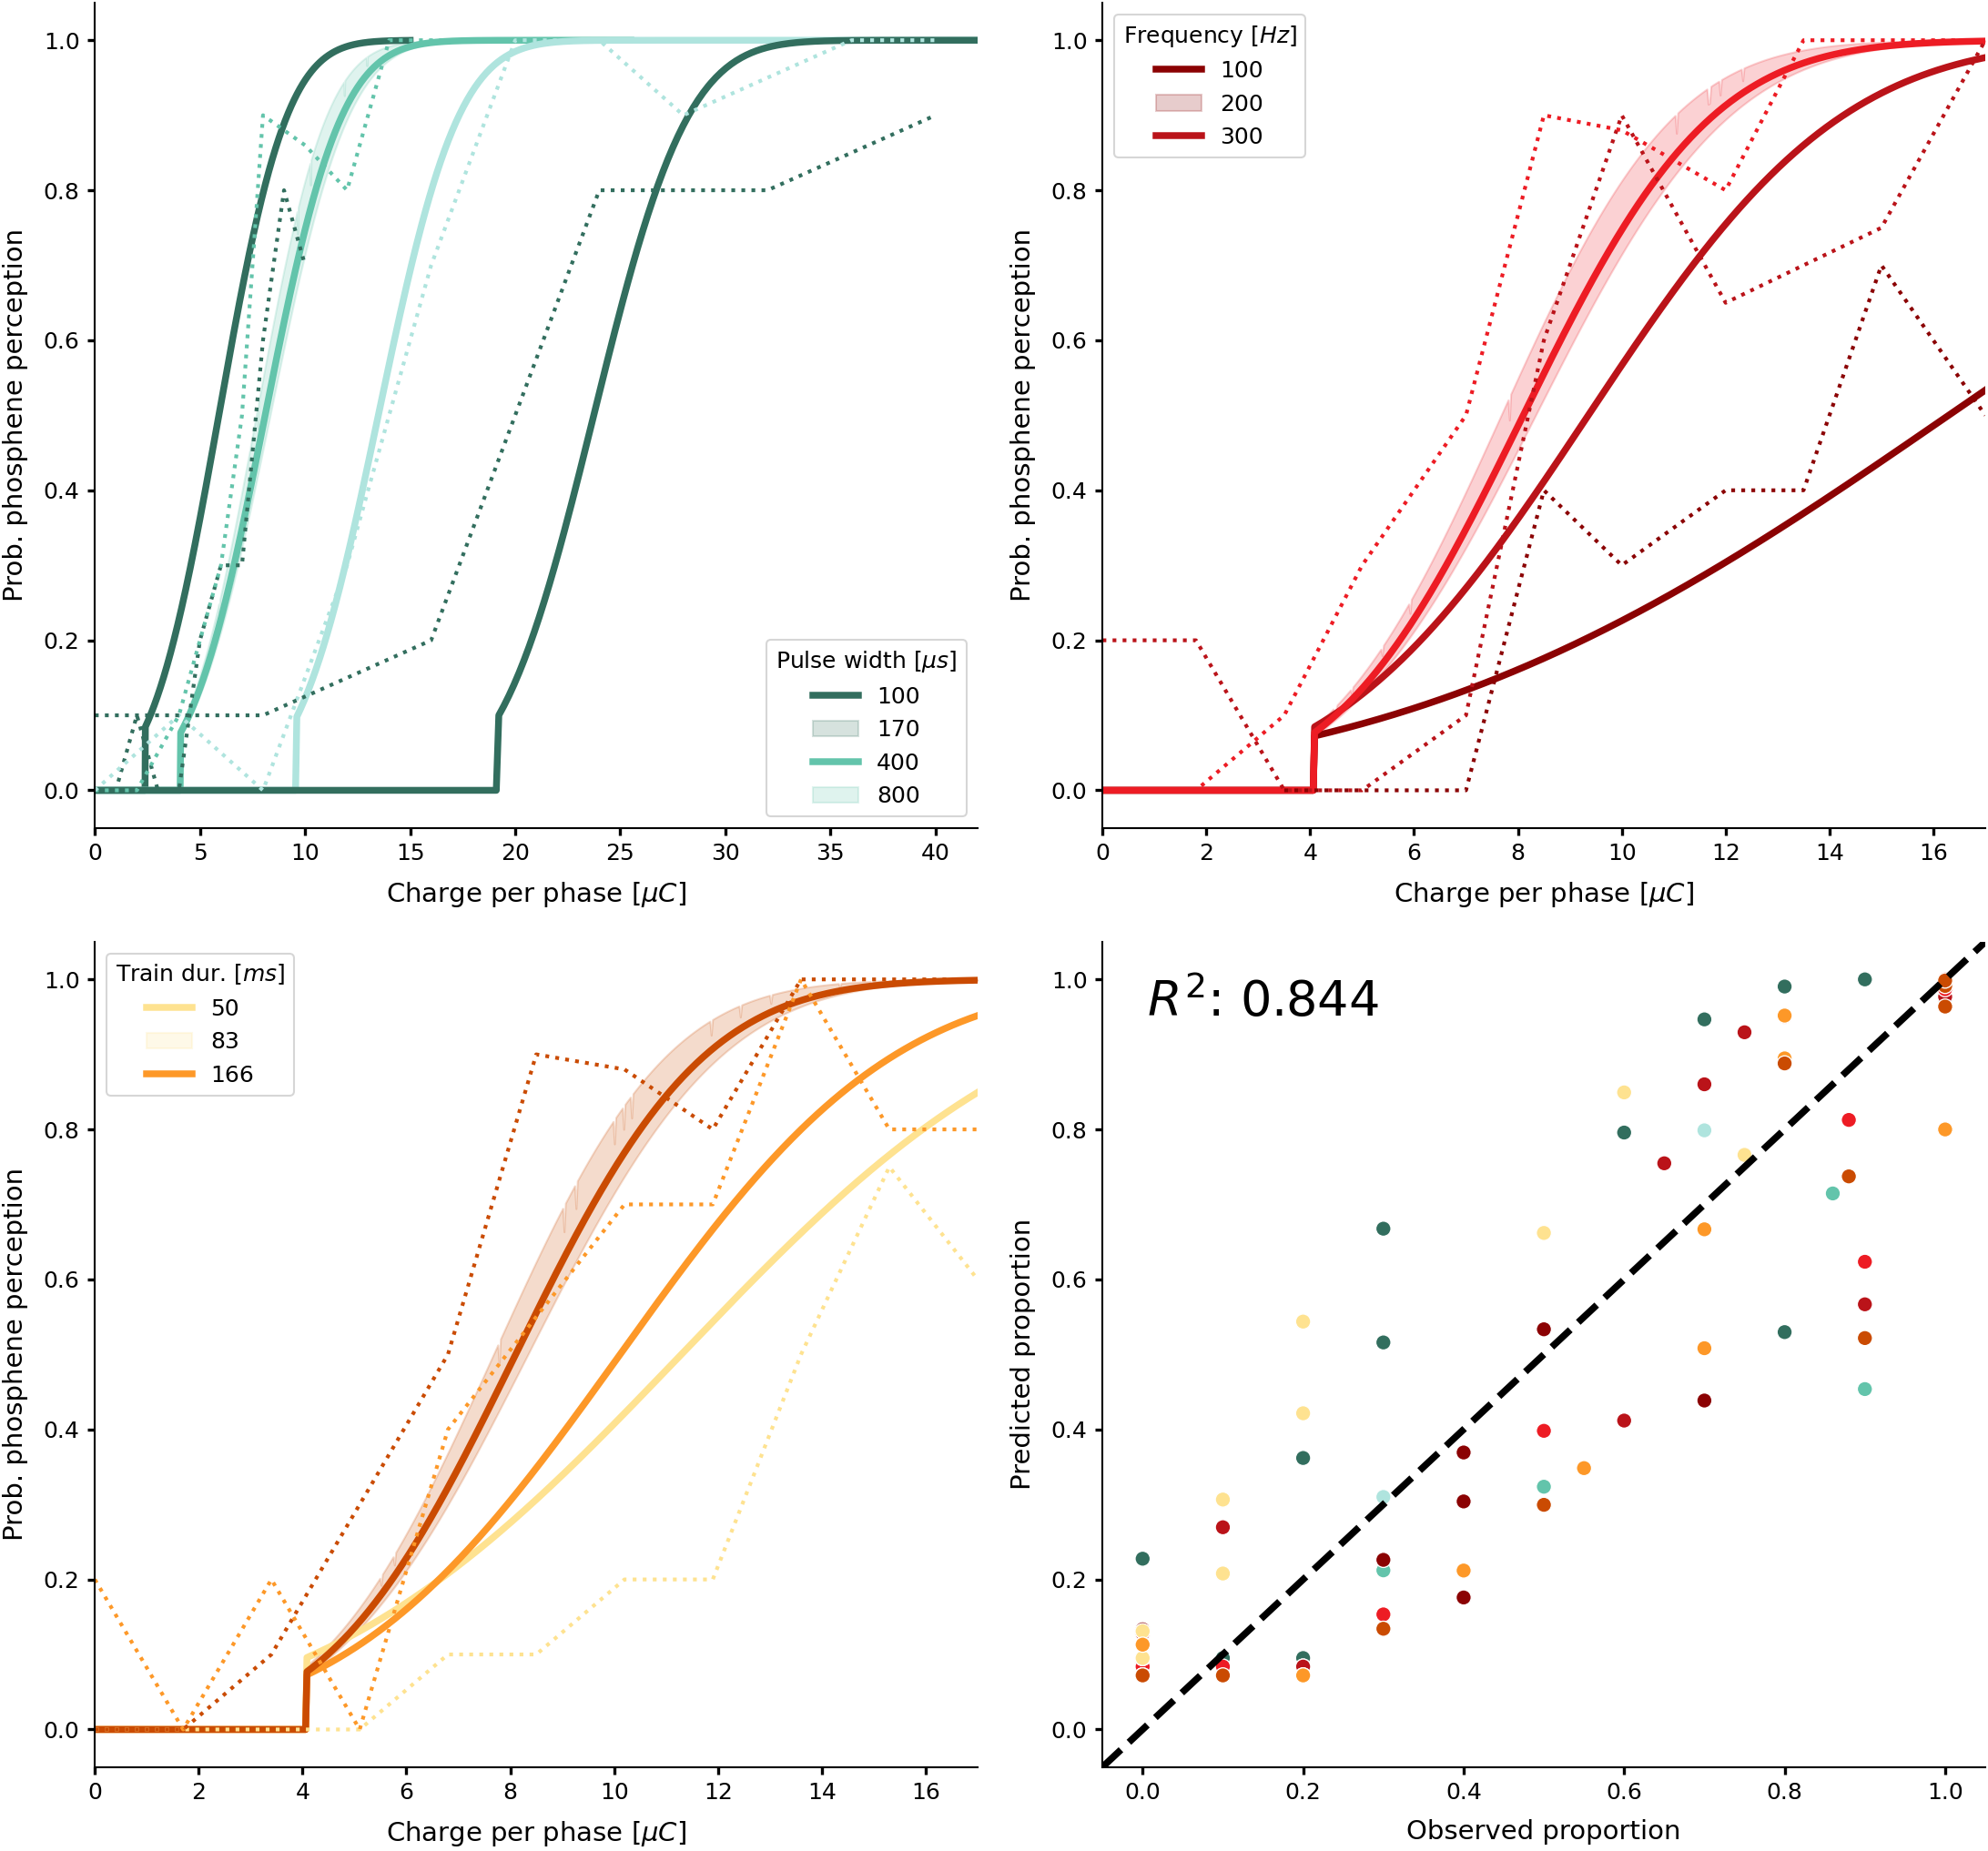

In [19]:
fig, axs = plt.subplots(2,2, figsize=(7.5,7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', COLORSTYLE['turquoise'], [0,42],),
                                                     ('fig2B','frequency', COLORSTYLE['red'], [0,17]),
                                                     ('fig2C','train_duration', COLORSTYLE['orange'], [0,17])]):  #[0,17])]):

    # Mask (select the datapoints for the correct experimental parameter: pw, f or td)
    mask = virtual_data[f'mask_{param}'].copy()
    print(mask.sum())
    if PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Change zero activation into crosses
        zero_activation = (virtual_data.max_activation_  == 0) # mask for the zero_activations
        sns.scatterplot(x=virtual_data.charge_per_phase[mask  & zero_activation]*1e9,
                     y=y_pred_interp[mask & zero_activation],
                     hue=virtual_data.loc[mask & zero_activation,param],
                     ax=axs.flatten()[i],
                     palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )),
                     marker = 'x',
                     s=15,
                     alpha = 0.5,
                     linewidths=1.)

    if PLOT_ZERO_ACTIVATIONS == 'ignore' or PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Don't plot a line for the zero activation
        nonzero_activation = ~(virtual_data.max_activation_  == 0) # mask for the nonzero activations
        mask = mask & nonzero_activation


    sns.lineplot(x=virtual_data.charge_per_phase[mask]*1e9,
                 y=y_pred_interp[mask],
                 hue=virtual_data.loc[mask,param],
                 ax=axs.flatten()[i],
                 palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )),
                 linestyle='-',
                 linewidth=1.8)



    # Lineplot (data)
    mask = data.label==label
    print(mask.shape)
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')


    axs.flatten()[i].set(xlim=xlim,
                         ylabel = 'Prob. phosphene perception',
                         xlabel = 'Charge per phase [$\mu C$]')


    # Scatterplot (model vs data)
    mask = data.label==label
    sns.scatterplot(x = y_true[mask],
                    y = y_pred[mask],
                    hue = data.loc[mask,param],
                    palette=sns.color_palette(colors, n_colors=len(data[param].unique())),
                    ax=axs.flatten()[-1],
                    legend=False)




# Neater legends (axs 0 to 3)
axs[0][0].legend(['100', '170','400','800'], title='Pulse width [$\mu s$]')
axs[0][1].legend(['100', '200','300'], title='Frequency [$Hz$]')
axs[1][0].legend(['50', '83','166'], title='Train dur. [$ms$]')

# Adjust final
axs[1][1].axline((0,0),(1,1), linestyle='--',color='k', linewidth=1.8)
axs[1][1].set(ylabel = 'Predicted proportion',
              xlabel = 'Observed proportion',)
axs[1][1].text(0.005,0.95,f"$R^2$: {regress.rvalue**2:.3f}", ha='left',fontsize=13)
plt.tight_layout()

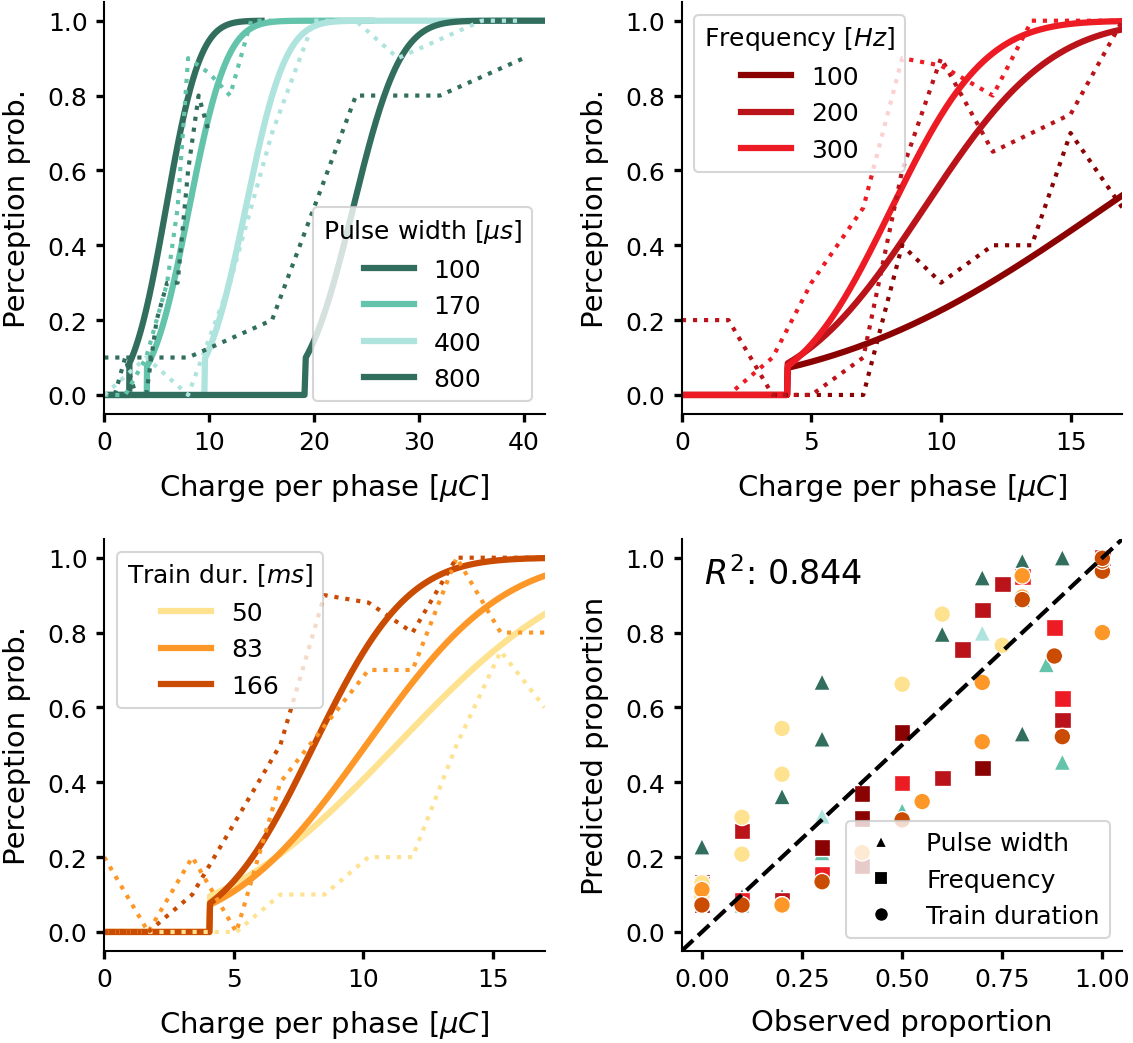

In [23]:
plt.style.use('../_figurestyle/small.mplstyle')
PLOT_ZERO_ACTIVATIONS = 'standard' # choose: 'standard', 'ignore', 'crosses'


# # Estimated proportion of active phosphenes as function of effective charge (normal cumulative density func.)
# func_prob = lambda tissue_act, sigma: norm.cdf(tissue_act, loc=rheobase*chronaxie, scale=sigma) 

# # # Curve fit (MODEL: max_activation_)
# func_prob = lambda x, mu=5.9307288148088016e-08, sigma=4.3836315254409424e-08: norm.cdf(x, mu, sigma)

# x = data.max_activation_
# y_true = data.proportion_phosphene_perception
# (A_thr,sigma,), _ = curve_fit(func_prob, x, y_true, p0=[50e-9, 2.2e-7], bounds=[[1e-11, 1.0e-10],[1e-6, 1.0e-5]])

# y_pred = func_prob(data.max_activation_, mu=A_thr, sigma=sigma)
# regress = linregress(y_true,y_pred)
# print(f'estimated activation threshold: {A_thr}, sigma: {sigma}, \nR^2: {regress.rvalue**2:.3f}')

# # Interpolated data points (for smooth prediction curve)
# x_interp = virtual_data.max_activation_
# y_pred_interp = func_prob(x_interp, mu=A_thr, sigma=sigma)
# y_pred_interp[virtual_data.max_activation_ == 0] = 0

fig, axs = plt.subplots(2,2, figsize=(4,3.7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', COLORSTYLE['turquoise'], [0,42],),
                                                     ('fig2B','frequency', COLORSTYLE['red'], [0,17]),
                                                     ('fig2C','train_duration', COLORSTYLE['orange'], [0,17])]): #[0,17])]): 
   
    # Zero activations



    # Mask (select the datapoints for the correct experimental parameter: pw, f or td)
    mask = virtual_data[f'mask_{param}'].copy()
    
    
    if PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Change zero activation into crosses 
        zero_activation = (virtual_data.max_activation_  == 0) # mask for the zero_activations
        sns.scatterplot(x=virtual_data.charge_per_phase[mask  & zero_activation]*1e9,
                     y=y_pred_interp[mask & zero_activation],
                     hue=virtual_data.loc[mask & zero_activation,param],
                     ax=axs.flatten()[i],
                     palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                     marker = 'x',
#                      s=15,
                     alpha = 0.5,
                     linewidths=1.)
        
    if PLOT_ZERO_ACTIVATIONS == 'ignore' or PLOT_ZERO_ACTIVATIONS == 'crosses': 
        # Don't plot a line for the zero activation 
        nonzero_activation = ~(virtual_data.max_activation_  == 0) # mask for the nonzero activations
        mask = mask & nonzero_activation


    sns.lineplot(x=virtual_data.charge_per_phase[mask]*1e9,
                 y=y_pred_interp[mask],
                 hue=virtual_data.loc[mask,param],
                 ax=axs.flatten()[i],
                 palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                 linestyle='-',
                 errorbar=None)
#                  linewidth=1.8)
    

    
    # Lineplot (data)
    mask = data.label==label
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')    
    

    axs.flatten()[i].set(xlim=xlim,
                         ylabel = 'Perception prob.',
                         xlabel = 'Charge per phase [$\mu C$]')
    
    
    # Scatterplot (model vs data)
    mask = data.label==label
    sns.scatterplot(x = y_true[mask],
                    y = y_pred[mask],
                    hue = data.loc[mask,param],
                    palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                    ax=axs.flatten()[-1],
                    marker= {'fig2A': '^',
                             'fig2B': 's',
                             'fig2C': 'o',}[label],
                    legend=False)    
    
        
    

# Neater legends (axs 0 to 3)
axs[0][0].legend(['100', '170','400','800'], title='Pulse width [$\mu s$]', loc='lower right')
axs[0][1].legend(['100', '200','300'], title='Frequency [$Hz$]', title_fontsize=6)
axs[1][0].legend(['50', '83','166'], title='Train dur. [$ms$]', title_fontsize=6)

legend_elements = [matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='^', label='Pulse width'),
                   matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='s', label='Frequency'),
                   matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='o', label='Train duration'),]
axs[1][1].legend(handles=legend_elements, loc='lower right', prop={'size': 6,})


# Adjust final 
axs[1][1].axline((0,0),(1,1), linestyle='--',color='k', linewidth=1.)
axs[1][1].set(ylabel = 'Predicted proportion',
              xlabel = 'Observed proportion',)
axs[1][1].text(0.005,0.93,f"$R^2$: {regress.rvalue**2:.3f}", ha='left')
plt.tight_layout()